In [ ]:
# default_exp data.cifar

In [ ]:
%load_ext lab_black

In [ ]:
# export

import pytorch_lightning as pl
import torchvision.transforms as T
import albumentations as A
import numpy as np

from torchvision import datasets
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader, random_split
from albumentations.core.composition import BaseCompose
from albumentations.core.transforms_interface import BasicTransform
from pathlib import Path
from PIL import Image

from typing import Callable, Optional, Any, Tuple

In [ ]:
# export
class CIFAR10(datasets.CIFAR10):

    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    num_classes = 10
    dims = (3, 32, 32)

    def __init__(
        self,
        data_dir: str = "~/data/cifar",
        train: bool = True,
        download=True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ):
        super(CIFAR10, self).__init__(
            data_dir,
            train=train,
            download=download,
            transform=transform,
            target_transform=target_transform,
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            if isinstance(self.transform, (BaseCompose, BasicTransform)):
                transformed = self.transform(image=image)
                image = transformed["image"]
            else:
                image = self.transform(image)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label

In [ ]:
# export
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "~/data/cifar",
        transform=T.Compose([T.ToTensor(), T.Normalize(CIFAR10.mean, CIFAR10.std)]),
        test_transform=T.Compose(
            [T.ToTensor(), T.Normalize(CIFAR10.mean, CIFAR10.std)]
        ),
    ):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.test_transform = test_transform
        self.mean = CIFAR10.mean
        self.std = CIFAR10.std
        self.num_classes = CIFAR10.num_classes
        self.dims = CIFAR10.dims

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.cifar_test = CIFAR10(
                self.data_dir, train=False, transform=self.test_transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.cifar_train, batch_size=32, num_workers=2, pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=32, num_workers=2, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(
            self.cifar_test, batch_size=32, num_workers=2, pin_memory=True
        )

In [ ]:
# export
class CIFAR10Mandelbrot(VisionDataset):
    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super(CIFAR10Mandelbrot, self).__init__(
            root, transform=transform, target_transform=target_transform
        )

        self.train = train

        self.source_dir: Path = Path(root) / ("train" if self.train else "test")

        self.data_paths: List[Any] = sorted(list(self.source_dir.glob("*/*.jpg")))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        data_path = self.data_paths[index]

        image = np.array(Image.open(data_path))
        target = int(data_path.parent.name)

        if self.transform is not None:
            if isinstance(self.transform, (BaseCompose, BasicTransform)):
                transformed = self.transform(image=image)
                image = transformed["image"]
            else:
                image = self.transform(image)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target

    def __len__(self) -> int:
        return len(self.data_paths)

In [ ]:
dset = CIFAR10Mandelbrot("../dev_nbs/cifar10_mandelbrot", train=True)

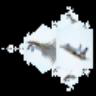

In [ ]:
Image.fromarray(dset[0][0])

In [ ]:
dset = CIFAR10Mandelbrot("../dev_nbs/cifar10_mandelbrot", train=False)

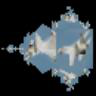

In [ ]:
Image.fromarray(dset[0][0])

In [ ]:
for image, label in iter(dset):
    pass

In [ ]:
# export
class CIFAR10MandelbrotDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "~/data/cifar",
        transform=T.Compose([T.ToTensor(), T.Normalize(CIFAR10.mean, CIFAR10.std)]),
        test_transform=T.Compose(
            [T.ToTensor(), T.Normalize(CIFAR10.mean, CIFAR10.std)]
        ),
    ):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.test_transform = test_transform
        self.mean = CIFAR10.mean
        self.std = CIFAR10.std
        self.num_classes = CIFAR10.num_classes
        self.dims = CIFAR10.dims

    def prepare_data(self):
        pass

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = CIFAR10Mandelbrot(
                self.data_dir, train=True, transform=self.transform
            )
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.cifar_test = CIFAR10Mandelbrot(
                self.data_dir, train=False, transform=self.test_transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.cifar_train, batch_size=32, num_workers=2, pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=32, num_workers=2, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(
            self.cifar_test, batch_size=32, num_workers=2, pin_memory=True
        )

In [ ]:
from nbdev.export import notebook2script

notebook2script()

Converted 01_data.cifar.ipynb.
Converted 02_transforms.fractal.ipynb.
Converted 03_model.dummy.ipynb.
Converted 03a_model.resnet18.ipynb.
Converted dev_setup.ipynb.
Converted index.ipynb.
